In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from catboost import CatBoostRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,target
0,236,488,16,221,382,97,-4.472136,0.107472,0,132,...,13.340874,0.870542,1.962937,7.466666,11.547794,8.822916,9.046424,7.895535,11.010677,20.107472
1,386,206,357,232,1,198,7.810250,0.763713,1,143,...,12.484882,7.168680,2.885415,12.413973,10.260494,10.091351,9.270888,3.173994,13.921871,61.763713
2,429,49,481,111,111,146,8.602325,0.651162,1,430,...,14.030257,0.394970,8.160625,12.592059,8.937577,2.265191,11.255721,12.794841,12.080951,74.651162
3,414,350,481,370,208,158,8.306624,0.424645,1,340,...,2.789577,6.416708,10.549814,11.456437,6.468099,2.519049,0.258284,9.317696,5.383098,69.424645
4,318,359,20,218,317,301,8.124038,0.767304,1,212,...,1.886560,1.919999,2.268203,0.149421,4.105907,10.416291,6.816217,8.586960,4.512419,66.767304


In [3]:
df_corr = df.corr()['target'].reset_index().rename(columns={'index': 'column', 'target': 'value'})
df_corr['value'] = df_corr['value'].abs()
features = df_corr.sort_values('value', ascending=False)[1:6].column.values.tolist()
features

['7', '40', '26', '39', '35']

In [4]:
target_col = 'target'

In [5]:
train = df[features+[target_col]]
train.describe()

,7,40,26,39,35,target
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,0.498548,7.479579,7.515753,7.507033,7.520193,50.033981
std,0.288682,4.326175,4.333907,4.327670,4.335244,28.897243
min,0.000014,0.000105,0.000017,0.000106,0.000078,0.002634
25%,0.248932,3.731527,3.746467,3.771945,3.752848,25.091903
50%,0.497136,7.452493,7.528984,7.504101,7.550623,50.030705
75%,0.747513,11.222543,11.272683,11.241504,11.261178,75.059454
max,0.999987,14.999704,14.999995,14.999933,14.999898,99.999482


In [8]:
##Can see that the features are just random ranmers with uniform distribution 
##But let's check ones again for the TOP 5 most correlated with Target features by plots

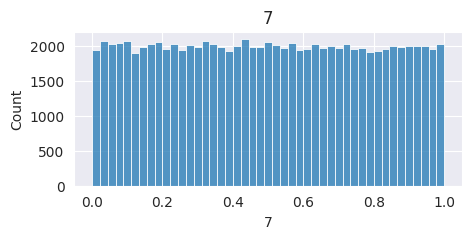

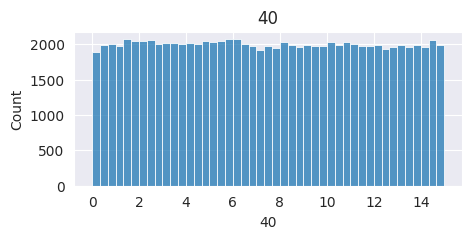

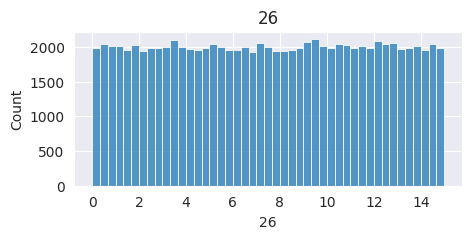

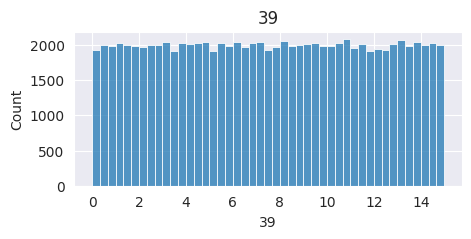

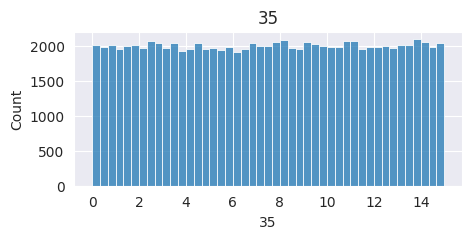

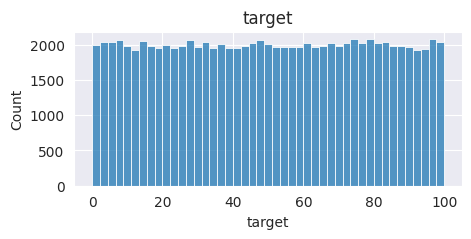

In [6]:
for col in train.columns:
    plt.figure(figsize=(5, 2))
    plt.title(col)
    sns.histplot(data=train, x=col)
    plt.show()

## overall EDA did not present any particular interesting inside for this use case. 
## But in the same time feature importance of the model Presents that Target column is 99% depend on the column 6, and rest for column 7 without dependancy on another columns at all

In [8]:
def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x.iloc[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x.iloc[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid


def evaluate(data_x, data_y, model, random_state=42, n_splits=5, test_x=None):
    skf    = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    test_y = np.zeros(len(data_x)) if (test_x is None) else np.zeros((len(test_x), n_splits))
    errors = []
    for i, (train_index, valid_index) in enumerate(skf.split(data_x, data_y.astype(str))):
        train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)
        model.fit(train_x, train_y)
        if test_x is None:
            test_y[valid_index] = model.predict(valid_x)
        else:
            test_y[:, i] = model.predict(test_x)
        pred = model.predict(valid_x)
        error = mean_squared_error(valid_y, pred, squared=False)
        print(f"FOLD {i+1}: ", error)
        errors.append(error)
    print('RMSE =', np.mean(errors))
    return test_y if (test_x is None) else np.mean(test_y, axis=1)

In [13]:
lgbm_params = {
    'verbose': 0,
    'random_state': 1010
}
xgbm_params = {
    # 'n_estimators': 500,
    'random_state': 1010
}
catboost_params = {
    'verbose': False
}
lgbm_model = LGBMRegressor(**lgbm_params)
xgbm_model = XGBRegressor(**xgbm_params)
catboost_model = CatBoostRegressor(**catboost_params)
print('LGBM')
evaluate(train[features].copy(), train[target_col].copy(), lgbm_model)
print('XGB')
evaluate(train[features].copy(), train[target_col].copy(), xgbm_model)
print('CatBoost')
evaluate(train[features].copy(), train[target_col].copy(), catboost_model)

LGBM
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
FOLD 1:  29.0460499777374
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_col_wise=true` to remove the overhead.
FOLD 2:  28.986683756117287
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
FOLD 3:  28.91568846135707
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
FOLD 4:  28.834081276135965
[LightGBM] [Warning] Auto-choosing

array([48.78110588, 50.81154996, 47.21388548, ..., 50.90207785,
       49.78326634, 48.68045627])

In [10]:
def rmse(y_true, y_pred, **kwargs):
    return mean_squared_error(y_true, y_pred, squared = False, **kwargs)

task = Task('reg')

In [11]:
roles = {
    'target': 'target'
}
N_THREADS = 4 # threads cnt for lightautoml
RANDOM_STATE = 42 # fixed random state for various reasons
TIMEOUT = 60
N_FOLDS = 5
automl = TabularUtilizedAutoML(task = task,
                               timeout = TIMEOUT,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS},
                               general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]}, # Use only linear models and LGBM and no CatBoost
                               tuning_params = {'max_tuning_time': 5 * 60}, # Set 25 minutes for LGBM params tuning
                               lgb_params = {'default_params': {'num_trees': 100000, 'learning_rate': 0.01, 'early_stopping_rounds': 1000}, # Set smaller LR and more ES rounds
                                             'freeze_defaults': True},
                              )
oof_pred = automl.fit_predict(train, roles = roles, verbose = 3)
print('OOF score: {}'.format(rmse(train[target_col].values, oof_pred.data[:, 0])))

[21:20:53] Start automl utilizator with listed constraints:
[21:20:53] - time: 60.00 seconds
[21:20:53] - CPU: 4 cores
[21:20:53] - memory: 16 GB

[21:20:53] If one preset completes earlier, next preset configuration will be started

[21:20:53] ==================================================
[21:20:53] Start 0 automl preset configuration:
[21:20:53] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[21:20:53] Found reader_params in kwargs, need to combine
[21:20:53] Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 42}
[21:20:53] Found general_params in kwargs, need to combine
[21:20:53] Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']], 'return_all_predictions': False}
[21:20:53] Stdout logging level is INFO3.
[21:20:53] Task: reg

[21:20:53] Start automl preset with listed constraints:
[21:20:53] - time: 60.0

## overall EDA did not present any particular interesting inside for this use case. 
## But in the same time feature importance of the model Presents that Target column is 99% depend on the column 6, and rest for column 7 without dependancy on another columns at all